<a href="https://colab.research.google.com/github/MissaMia/MissaMia/blob/main/final_AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: Вариант 3. Описание задачи

Представьте, что вы работаете в крупном приложении для знакомств. Помимо стандартных функций, пользователям доступна платная премиум-подписка с рядом полезных дополнительных возможностей.

Команда провела A/B-тест: для новых пользователей из нескольких стран была изменена цена премиум-подписки при оплате через две новые платёжные системы. Стоимость пробного периода при этом не менялась.

**Ваша задача:**

Оценить, дал ли эксперимент положительный эффект в целом.

Подписка автоматически продлевается каждый месяц, пока пользователь сам её не отменит.

## Данные

Всего есть три группы:
- **Тестовая** (`test`)
- **Контрольная 1** (`control_1`)
- **Контрольная 2** (`control_2`)

Для каждой из них предоставлены два набора данных:

### Файлы `users_*.csv` — информация о пользователях:
- `uid` — идентификатор пользователя
- `age` — возраст
- `attraction_coeff` — коэффициент привлекательности (от 0 до 1000, рассчитывается как (лайки / просмотры) × 1000)
- `coins` — число монеток (внутренняя валюта)
- `country` — страна
- `visit_days` — в какие дни после регистрации пользователь посещал приложение (например, в 1-й день, затем на 7-й день)
- `gender` — пол
- `age_filter_start` — минимальный возраст поиска
- `age_filter_end` — максимальный возраст поиска
- `views_count` — количество полученных оценок
- `was_premium` — был ли когда-либо премиум-пользователем (либо с пробным периодом, либо с покупкой)
- `is_premium` — является ли сейчас премиум-пользователем
- `total_revenue` — нормированная выручка

### Файлы `transactions_*.csv` — информация о платежах пользователей:
- `uid` — идентификатор пользователя
- `country` — страна
- `joined_at` — дата и время регистрации
- `paid_at` — дата и время покупки
- `revenue` — нормированная выручка
- `payment_id` — идентификатор платежа
- `from_page` — откуда пользователь перешел на страницу оплаты
- `product_type` — тип продукта:
  - `trial_premium` — пробная премиум-подписка
  - `premium_no_trial` — премиум-подписка без пробного периода
  - `coins` — покупка через внутреннюю валюту
  - `other_type` — другие типы покупок


In [ ]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.proportion as smp

### Предобработка и EDA

In [ ]:
# читаем данные
users_test = pd.read_csv('Проект_3_users_test.csv', sep = ';')
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', sep = ';')
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', sep = ';')
transactions_test = pd.read_csv('Проект_3_transactions_test.csv', sep = ';')
transactions_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep = ';')
transactions_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep = ';')

In [ ]:
#Просматриваем все данные
users_test.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0


In [ ]:
users_control_1.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0


In [ ]:
 users_control_2.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0


In [ ]:
 transactions_test.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [ ]:
 transactions_control_1.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins


In [ ]:
 transactions_control_2.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium


In [ ]:
# Сохраняем копии для изменения
users_test = users_test.copy()
users_control_1 = users_control_1.copy()
users_control_2 = users_control_2.copy()
tx_test = transactions_test.copy()
tx_control_1 = transactions_control_1.copy()
tx_control_2 = transactions_control_2.copy()

In [ ]:
#Убедимся, что один и тот же пользователь (`uid`) не встречается одновременно в двух или более выборках.

print(len(users_test.merge(users_control_2, on = 'uid')))
print(len(users_test.merge(users_control_1, on = 'uid')))
print(len(users_control_2.merge(users_control_1, on = 'uid')))
print(len(transactions_test.merge(users_control_2, on = 'uid')))
print(len(transactions_test.merge(users_control_1, on = 'uid')))
print(len(transactions_control_2.merge(users_control_1, on = 'uid')))

0
0
0
0
0
0


In [ ]:
# В каждом датафрейме создаём колонку 'sample' с признаком выборки:
# 't' - тестовая выборка
# 'c1' - контрольная 1
# 'c2' - контрольная 2

users_test['sample'] = 't'
users_control_1['sample'] = 'c1'
users_control_2['sample'] = 'c2'

transactions_test['sample'] = 't'
transactions_control_1['sample'] = 'c1'
transactions_control_2['sample'] = 'c2'


In [ ]:
# Объединим таблицы users и transactions из разных выборок
users = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)
print(len(users) == len(users_test) + len(users_control_1) + len(users_control_2))
print(len(transactions) == len(transactions_test) + len(transactions_control_1) + len(transactions_control_2))


True
True


In [ ]:
 # сделаем копии объединённых таблиц, эти данные не будем изменять в работе
orig_users = users.copy()
orig_transactions = transactions.copy()

# Описание таблицы `users`

- **uid** — идентификатор пользователя
- **age** — возраст пользователя
- **attraction_coeff** — коэффициент привлекательности (от 0 до 1000), рассчитывается как (лайки / просмотры) * 1000
- **coins** — количество монеток (внутренняя валюта)
- **country** — страна пользователя
- **visit_days** — дни после регистрации, в которые пользователь посещал приложение (например: в 1, затем в 7)
- **gender** — пол пользователя
- **age_filter_start** — минимальный возраст в фильтре поиска
- **age_filter_end** — максимальный возраст в фильтре поиска
- **views_count** — количество полученных оценок
- **was_premium** — был ли когда-либо премиум (либо пробный, либо купленный премиум)
- **is_premium** — является ли премиум на данный момент
- **total_revenue** — нормированная выручка


In [ ]:
 users

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,sample
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,t
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,t
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,t
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,t
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0,c2
12908,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0,c2
12909,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0,c2
12910,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0,c2


In [ ]:
 users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             170 non-null    float64
 4   country           12912 non-null  object 
 5   visit_days        8894 non-null   object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       1255 non-null   float64
 11  is_premium        540 non-null    float64
 12  total_revenue     12912 non-null  int64  
 13  sample            12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


In [ ]:
# посмотрим статистику
users.describe(include='all')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,sample
count,1.291200e+04,12912.000000,12912.000000,170.000000,12912,8894,12912.000000,12912.000000,12912.000000,12912.000000,1255.0,540.0,12912.000000,12912
unique,NaN,NaN,NaN,NaN,72,2132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,United States of America,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c1
freq,NaN,NaN,NaN,NaN,4407,1704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4340
mean,8.917569e+08,32.010378,315.455545,688.958824,NaN,NaN,0.955158,26.815985,38.568463,46.641032,1.0,1.0,526.837283,NaN
std,1.610285e+06,10.224415,323.488766,7690.943033,NaN,NaN,0.206965,9.447197,15.511204,285.324194,0.0,0.0,5524.662716,NaN
min,8.910509e+08,16.000000,0.000000,1.000000,NaN,NaN,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000,NaN
25%,8.913565e+08,25.000000,0.000000,6.000000,NaN,NaN,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000,NaN
50%,8.917255e+08,30.000000,250.000000,10.000000,NaN,NaN,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000,NaN
75%,8.920860e+08,38.000000,529.000000,28.000000,NaN,NaN,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000,NaN


## Первичный осмотр данных

В ходе первичного анализа не было выявлено явных логических несоответствий:

- Возраст пользователей находится в допустимых пределах.
- Коэффициент привлекательности укладывается в ожидаемый диапазон (от 0 до 1000).
- Пользователи представлены из 72 стран; наибольшая доля приходится на **США** (примерно 34%).
- Обнаружен выраженный дисбаланс по полу: примерно **1 мужчина на 20 женщин**.
- Есть случаи, когда пользователи ищут партнёров старше 96 лет — такие случаи допустимы и не требуют исключения.



## Анализ столбца `coins`

- В выборке **отсутствуют значения, равные нулю**.
- Пропущенные значения, вероятнее всего, означают, что пользователь не пользовался внутриигровой валютой, и их **целесообразно трактовать как нули**.


In [ ]:
# в столбце coins меняем пропущенные значения на нули
users.coins.fillna(0, inplace = True)

###  Посмотрим колонки visit_days.

In [ ]:
 # заменим нулями пропущенные значения
users.visit_days.fillna(0, inplace = True)
 # приведём значения в списках к типу int
users['visit_days'] = users['visit_days'].apply(
    lambda x: [int(i) for i in str(x).replace('[','').replace(']','').split(',') if i.strip().isdigit()]
)
# добавляем ноль в начало списка для тех строк, которые не были пустыми
for v_d in users.visit_days:
    if v_d != [0]:
        v_d.insert(0, 0)

In [ ]:
 users.visit_days

0        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16,...
1                                                      [0]
2        [0, 1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...
3               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
4                                                      [0]
                               ...                        
12907                                            [0, 1, 2]
12908      [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16]
12909                                                  [0]
12910                   [0, 2, 3, 5, 7, 9, 10, 12, 14, 15]
12911                                                  [0]
Name: visit_days, Length: 12912, dtype: object

In [ ]:
 # создадим новую колонку visit_counts, в которую запишем число посещений приложения после регистрации
users['visit_count'] = users['visit_days'].apply(lambda x: len(x) - 1)
users['visit_count'].max()

31

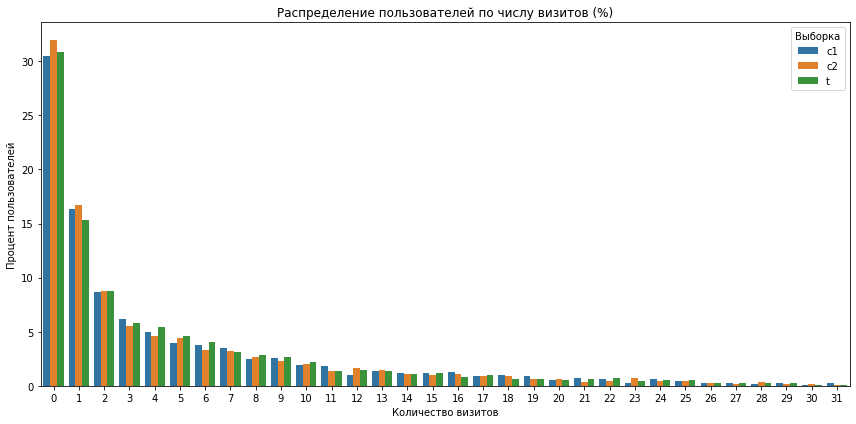

In [ ]:
# Подсчёт распределения visit_count по выборкам
visit_dist = (
    users.groupby(['visit_count', 'sample'])
    .size()
    .reset_index(name='count')
)

total_by_group = visit_dist.groupby('sample')['count'].transform('sum')
visit_dist['percent'] = (visit_dist['count'] / total_by_group * 100).round(2)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=visit_dist,
    x='visit_count',
    y='percent',
    hue='sample',
    order=sorted(users['visit_count'].unique())
)

plt.title("Распределение пользователей по числу визитов (%)")
plt.xlabel("Количество визитов")
plt.ylabel("Процент пользователей")
plt.legend(title="Выборка")
plt.tight_layout()
plt.show()

## Проверка различий в распределениях `visit_counts`

Визуальный анализ показал, что распределения по количеству посещений (`visit_counts`) между группами существенно не отличаются.

Для статистической проверки использовался **тест Манна–Уитни**.

- **Нулевая гипотеза (H₀):** распределения одинаковы, статистически значимых различий между группами нет.
- **Альтернативная гипотеза (H₁):** распределения различаются.
- **Уровень значимости:** 0,05


In [ ]:
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['visit_count'], users.query("sample == 'c1'")['visit_count'])[1])

p-value = 0.9911566023816412


In [ ]:
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['visit_count'], users.query("sample == 'c2'")['visit_count'])[1])

p-value = 0.08805032202688529


In [ ]:
print('p-value =', st.mannwhitneyu(users.query("sample == 'c1'")['visit_count'], users.query("sample == 'c2'")['visit_count'])[1])

p-value = 0.0839835081866715


Полученные значения p-value для всех трех пар превышают установленный уровень значимости 0,05, что свидетельствует об отсутствии статистически значимых различий между выборками в распределении пользователей по возрасту.

### Посмотрим колонки was_premium и is_premium

In [ ]:
# посмотрим уникальные значения в колонках
print(users.was_premium.unique())
print(users.is_premium.unique())

[nan  1.]
[nan  1.]


In [ ]:
users.was_premium.fillna(0, inplace = True)
users.is_premium.fillna(0, inplace = True)
users.was_premium = users.was_premium.apply(lambda x: int(x))
users.is_premium = users.is_premium.apply(lambda x: int(x))
print(users.was_premium.unique())
print(users.is_premium.unique())

[0 1]
[0 1]


### Посмотрим колонки gender

In [ ]:
# создадим таблицу с числом пользователей с разбивкой по гендерам и выборкам
gender_table = users.pivot_table(index = 'gender', columns = 'sample', values = 'uid', aggfunc = 'count')
gender_table

sample,c1,c2,t
gender,,,
0,182,195,202
1,4158,4069,4106


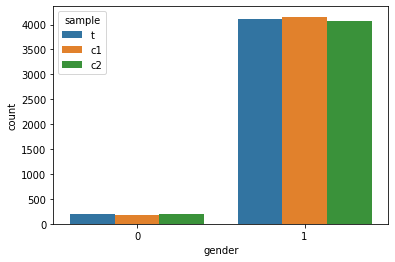

In [ ]:
#fig, axs = plt.subplots(1, 1, figsize=(12, 7))
sns.countplot(data=users, x="gender", hue="sample");

## Проверка различий в распределениях по полу

Визуальный анализ показал, что распределения по полу между выборками не имеют очевидных отличий.

Для статистической проверки использовался **хи-квадрат тест (χ²)**.

- **Нулевая гипотеза (H₀):** различий в распределениях по полу между группами нет.
- **Альтернативная гипотеза (H₁):** различия в распределениях есть.
- **Уровень значимости:** 0,05


In [ ]:
# сравним test и control_1
print('p-value =', st.chi2_contingency(gender_table[['t', 'c1']])[1])

p-value = 0.28640382402109243


In [ ]:
 # сравним test и control_2
print('p-value =', st.chi2_contingency(gender_table[['t', 'c2']])[1])

p-value = 0.838641703357504


In [ ]:
 # сравним control_1 и control_2
print('p-value =', st.chi2_contingency(gender_table[['c2', 'c1']])[1])

p-value = 0.41940247806709796


Значимых различий между выборками в распределении пользователей по гендерам нет.

### Посмотрим колонки uid

In [ ]:
# убедимся, что поле uid содержит уникальные значения
print(users_test.uid.duplicated().sum())
print(users_control_1.uid.duplicated().sum())
print(users_control_2.uid.duplicated().sum())

0
0
0


### Посмотрим колонки age

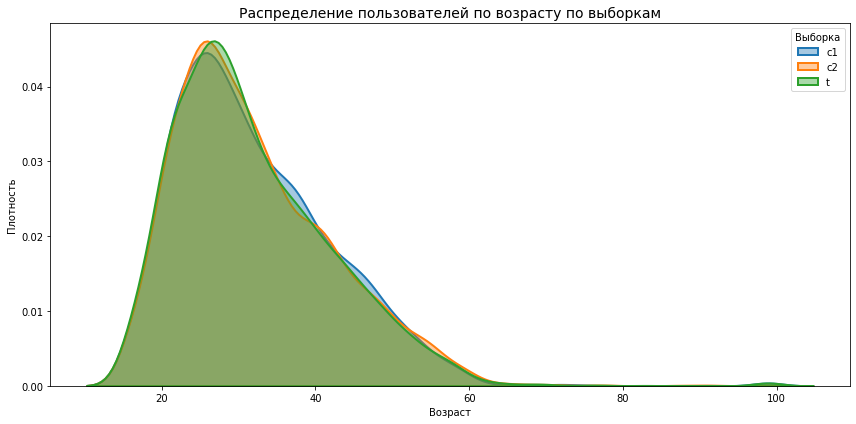

In [ ]:
plt.figure(figsize=(12, 6))

for label, df in users.groupby('sample'):
    sns.kdeplot(
        data=df,
        x="age",
        fill=True,
        common_norm=False,
        alpha=0.4,
        linewidth=2,
        label=label
    )

plt.title("Распределение пользователей по возрасту по выборкам", fontsize=14)
plt.xlabel("Возраст")
plt.ylabel("Плотность")
plt.legend(title="Выборка")
plt.tight_layout()
plt.show()

## Проверка различий в распределениях по возрасту

Визуальный анализ не выявил заметных различий в распределениях возраста между группами.

Для статистической проверки использовался **тест Манна–Уитни**.

- **Нулевая гипотеза (H₀):** различий в распределениях по возрасту между группами нет.
- **Альтернативная гипотеза (H₁):** различия есть.
- **Уровень значимости:** 0,05


In [ ]:
# сравним test и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['age'], users.query("sample == 'c1'")['age'])[1])

p-value = 0.30680267645865966


In [ ]:
# сравним test и control_2
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['age'], users.query("sample == 'c2'")['age'])[1])

p-value = 0.45885860388639843


In [ ]:
# сравним control_2 и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 'c1'")['age'], users.query("sample == 'c2'")['age'])[1])

p-value = 0.7919291369256963


Полученные значения p-value для всех трех пар превышают установленный уровень значимости 0,05, что свидетельствует об отсутствии статистически значимых различий между выборками в распределении пользователей по возрасту.

### Посмотрим колонки attraction_coeff

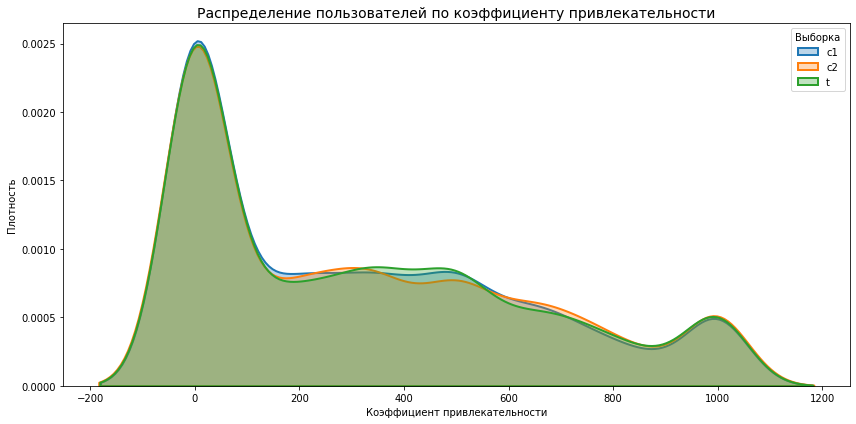

In [ ]:
plt.figure(figsize=(12, 6))
for label, df in users.groupby('sample'):
    sns.kdeplot(
        data=df,
        x="attraction_coeff",
        fill=True,
        common_norm=False,
        alpha=0.3,
        linewidth=2,
        label=label
    )

plt.title("Распределение пользователей по коэффициенту привлекательности", fontsize=14)
plt.xlabel("Коэффициент привлекательности")
plt.ylabel("Плотность")
plt.legend(title="Выборка")
plt.tight_layout()
plt.show()

## Проверка различий в распределениях коэффициента привлекательности

Визуальный анализ показал, что распределения коэффициента привлекательности между группами не имеют явных отличий.

Для статистической проверки использовался **тест Манна–Уитни**.

- **Нулевая гипотеза (H₀):** распределения не отличаются, статистически значимых различий между группами нет.
- **Альтернативная гипотеза (H₁):** различия в распределениях присутствуют.
- **Уровень значимости:** 0,05


In [ ]:
 # сравним test и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['attraction_coeff'], users.query("sample == 'c1'")['attraction_coeff'])[1])

p-value = 0.6352175892456173


In [ ]:
# сравним test и control_2
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['attraction_coeff'], users.query("sample == 'c2'")['attraction_coeff'])[1])

p-value = 0.9378076869815641


In [ ]:
 # сравним control_2 и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 'c1'")['attraction_coeff'], users.query("sample == 'c2'")['attraction_coeff'])[1])

p-value = 0.6876012572220559


Полученные значения p-value для всех трёх пар выборок превышают установленный уровень значимости 0,05. Это указывает на отсутствие статистически значимых различий в распределениях коэффициента привлекательности между группами пользователей.


### Посмотрим колонки country

In [ ]:
 # проверим названия стран на наличие дубликатов
sorted(list(users['country'].unique()))

['Algeria',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Belarus',
 'Belgium',
 'Bolivia',
 'Brazil',
 'Burkina Faso',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Czech Republic',
 'Dominican Republic',
 'Egypt',
 'France',
 'Gambia',
 'Georgia',
 'Germany',
 'Guatemala',
 'Hungary',
 'India',
 'Indonesia',
 'Iraq',
 'Islamic Republic of Iran',
 'Israel',
 'Italy',
 'Jamaica',
 'Korea, Republic of',
 'Kuwait',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Malaysia',
 'Mali',
 'Mexico',
 'Moldova, Republic of',
 'Monaco',
 'Morocco',
 'Nepal',
 'New Zealand',
 'Nicaragua',
 'Pakistan',
 'Panama',
 'Paraguay',
 'Peru',
 'Philippines',
 'Portugal',
 'Puerto Rico',
 'Qatar',
 'Romania',
 'Russian Federation',
 'Singapore',
 'Somalia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Tajikistan',
 'Tunisia',
 'Turkey',
 'Uganda',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America',
 'Uruguay',
 'Uzbekistan',
 'Venezu

In [ ]:
 users['country'].nunique()

72

In [ ]:
 # посмотрим на распределение пользователей по странам, разбивке по странам и выборкам, сначала выводим первые 36 стран
users.pivot_table(index = 'country', columns = 'sample', values = 'uid', aggfunc = 'count') \
    .sort_values(by = 't', ascending = False) \
    .head(36)

sample,c1,c2,t
country,,,
United States of America,1471.0,1486.0,1450.0
Argentina,389.0,397.0,396.0
France,370.0,376.0,359.0
Italy,338.0,293.0,323.0
Spain,342.0,310.0,301.0
Chile,287.0,286.0,272.0
United Arab Emirates,207.0,211.0,226.0
Germany,188.0,202.0,209.0
United Kingdom (Great Britain),146.0,146.0,169.0


In [ ]:
# ... затем остальные 36
users.pivot_table(index = 'country', columns = 'sample', values = 'uid', aggfunc = 'count') \
    .sort_values(by = 't', ascending = False) \
    .tail(36)

sample,c1,c2,t
country,,,
Azerbaijan,NaN,NaN,1.0
Bolivia,NaN,NaN,1.0
Brazil,NaN,NaN,1.0
Colombia,1.0,2.0,1.0
Costa Rica,1.0,1.0,1.0
Dominican Republic,2.0,1.0,1.0
Gambia,NaN,NaN,1.0
Monaco,NaN,NaN,1.0
Georgia,NaN,1.0,1.0


## География пользователей

Были выделены **топ-15 стран** по количеству пользователей. Некоторые страны оказались представлены не во всех трёх выборках, однако нет оснований полагать, что пользователи из какой-либо страны изначально имели ограничения на попадание в одну из групп.

Для упрощения анализа:
- Страны, не вошедшие в топ-15, были **сгруппированы по регионам**.
- **Новая Зеландия была объединена с Австралией**.


In [ ]:
# Сформируем словарь регионов:
# - ключ: название региона
# - значение: список стран в этом регионе
# Включим все страны, не попавшие в ТОП-15 по числу пользователей.
# Объединим Новую Зеландию с Австралией в регион "Австралия+".
# В результате словарь должен содержать 58 стран.
regions = {
    'Middle_East+':   ['Algeria', 'Burkina Faso', 'Egypt', 'Gambia', 'Mali', 'Morocco', 'Somalia', 'Tunisia', 'Uganda',
                       'Iraq', 'Islamic Republic of Iran', 'Kuwait', 'Qatar', 'Turkey'],
    'Latin_America':  ['Bolivia', 'Brazil', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Guatemala', 'Jamaica', 'Mexico',
                       'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Uruguay', 'Venezuela'],
    'USSR':           ['Armenia', 'Azerbaijan', 'Belarus', 'Georgia', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                       'Moldova, Republic of', 'Russian Federation', 'Tajikistan', 'Ukraine', 'Uzbekistan'],
    'Europe':         ['Austria', 'Czech Republic', 'Hungary', 'Monaco', 'Romania', 'Sweden'],
    'Asia':           ['China', 'India', 'Indonesia', 'Korea, Republic of', 'Malaysia', 'Nepal', 'Pakistan', 'Philippines',
                       'Singapore'],
    'Australia+':     ['New Zealand', 'Australia']
}

In [ ]:
len(regions['Middle_East+'] + regions['Latin_America'] + regions['USSR'] + regions['Europe'] + regions['Asia'] + regions['Australia+'])

58

In [ ]:
# создадим словарь
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region
# создадим колонку region
users['region'] = users['country'].map(country_to_region).fillna(users['country'])
# создадим таблицу с числом пользователей с разбивкой по регионам и выборкам
region_table = users.pivot_table(index = 'region', columns = 'sample', values = 'uid', aggfunc = 'count')
region_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
region,,,
United States of America,1471,1486,1450
Argentina,389,397,396
France,370,376,359
Italy,338,293,323
Spain,342,310,301
Chile,287,286,272
United Arab Emirates,207,211,226
Germany,188,202,209
United Kingdom (Great Britain),146,146,169


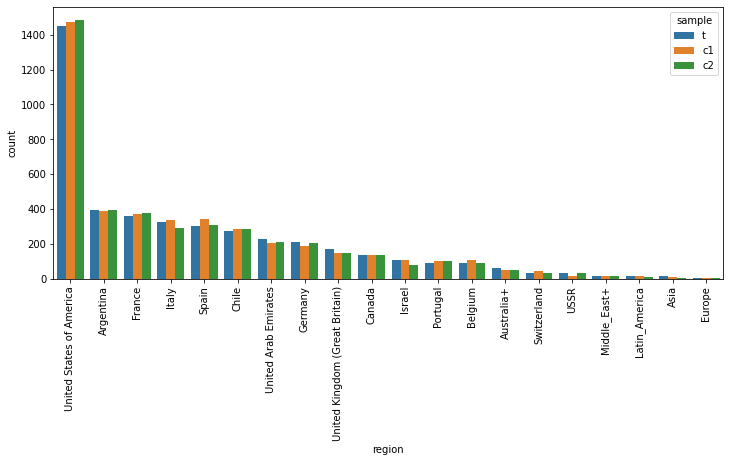

In [ ]:
region
region_counts = users['region'].value_counts()
region_frequency_map = region_counts.to_dict()
users['region_frequency'] = users['region'].map(region_frequency_map)
users.sort_values('region_frequency', ascending=False, inplace = True)
users.drop('region_frequency', axis=1, inplace=True)

# визуализируем распределение по регионам
plt.figure(figsize = (12, 5))
plt.xticks(rotation=90)
sns.countplot(data=users, x="region", hue="sample");

## Проверка различий в распределениях по регионам

Визуальный анализ не выявил существенных отличий в распределениях пользователей по регионам между выборками.

Для статистической проверки использовался **хи-квадрат тест (χ²)**.

- **Нулевая гипотеза (H₀):** статистически значимых различий в распределениях по регионам между группами нет.
- **Альтернативная гипотеза (H₁):** различия в распределениях имеются.
- **Уровень значимости:** 0,05


In [ ]:
 # сравним test и control_1
print('p-value =', st.chi2_contingency(region_table[['t', 'c1']])[1])

p-value = 0.6299122507023047


In [ ]:
# сравним test и control_2
print('p-value =', st.chi2_contingency(region_table[['t', 'c2']])[1])

p-value = 0.7512444934705236


In [ ]:
# сравним control_1 и control_2
print('p-value =', st.chi2_contingency(region_table[['c2', 'c1']])[1])

p-value = 0.5356176673789813


### Посмотрим колонки views_count.

Для визуализации разобьём распределение по границе views_count = 200

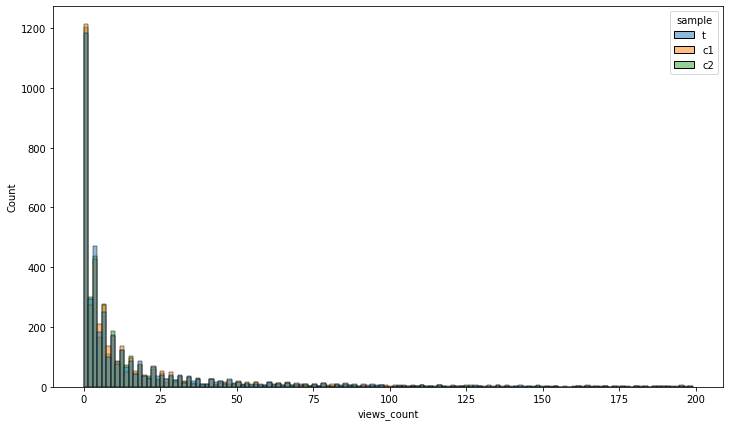

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(data=users[users.views_count < 200], x="views_count", hue="sample");

## Проверка различий в распределениях количества полученных оценок

Визуальный анализ показал, что распределения количества полученных оценок между выборками не имеют заметных отличий.

Для статистической проверки использовался **тест Манна–Уитни**.

- **Нулевая гипотеза (H₀):** распределения по количеству полученных оценок между группами не отличаются.
- **Альтернативная гипотеза (H₁):** имеются статистически значимые различия.
- **Уровень значимости:** 0,05


In [ ]:
# сравним test и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['views_count'], users.query("sample == 'c1'")['views_count'])[1])

p-value = 0.6944227626371243


In [ ]:
# сравним test и control_2
print('p-value =', st.mannwhitneyu(users.query("sample == 't'")['views_count'], users.query("sample == 'c2'")['views_count'])[1])

p-value = 0.21730170064760956


In [ ]:
# сравним control_2 и control_1
print('p-value =', st.mannwhitneyu(users.query("sample == 'c1'")['views_count'], users.query("sample == 'c2'")['views_count'])[1])

p-value = 0.4067256310455556


## Проверка различий по количеству полученных оценок

Полученные значения p-value для всех трёх пар выборок превышают установленный уровень значимости 0,05. Это указывает на отсутствие статистически значимых различий в распределениях количества полученных оценок между группами пользователей.

---

## Описание таблицы `transactions`

Таблица `transactions` содержит информацию о платёжных действиях пользователей:

- `uid` — идентификатор пользователя  
- `country` — страна  
- `joined_at` — дата и время регистрации  
- `paid_at` — дата и время покупки  
- `revenue` — нормированная выручка  
- `payment_id` — идентификатор платежа  
- `from_page` — страница, с которой пользователь перешёл к оплате  
- `product_type` — тип продукта:
  - `trial_premium` — пробная премиум-подписка  
  - `premium_no_trial` — премиум-подписка без пробного периода  
  - `coins` — покупка за внутреннюю валюту  
  - `other_type` — прочие типы продуктов


In [ ]:
transactions

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,t
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,t
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,t
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,t
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,t
...,...,...,...,...,...,...,...,...,...
1603,891985866.0,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147.0,trial_vip_popup,trial_premium,c2
1604,891491145.0,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727.0,147.0,send_message,trial_premium,c2
1605,892053750.0,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261.0,19.0,autorefill,coins,c2
1606,891668253.0,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997.0,147.0,trial_vip_popup,trial_premium,c2


In [ ]:
 # посмотрим типы данных и пропущенные знаечния
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           978 non-null    float64
 1   country       978 non-null    object 
 2   joined_at     1608 non-null   object 
 3   paid_at       1608 non-null   object 
 4   revenue       978 non-null    float64
 5   payment_id    978 non-null    float64
 6   from_page     978 non-null    object 
 7   product_type  978 non-null    object 
 8   sample        1608 non-null   object 
dtypes: float64(3), object(6)
memory usage: 113.2+ KB


 Колонки joined_at и paid_at приводим к типу datetime.
 Колонки uid, revenue и payment_id к типу int. Убрать пропущенные значения.

In [ ]:
# удалим строки, содержащие пропущенные значения и посмотрим результат
transactions.dropna(inplace = True)
transactions.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           978 non-null    float64
 1   country       978 non-null    object 
 2   joined_at     978 non-null    object 
 3   paid_at       978 non-null    object 
 4   revenue       978 non-null    float64
 5   payment_id    978 non-null    float64
 6   from_page     978 non-null    object 
 7   product_type  978 non-null    object 
 8   sample        978 non-null    object 
dtypes: float64(3), object(6)
memory usage: 76.4+ KB


In [ ]:
# приведём данные к типам int и datetime
transactions['uid'] = transactions['uid'].apply(lambda x: int(x))
transactions['revenue'] = transactions['revenue'].apply(lambda x: int(x))
transactions['payment_id'] = transactions['payment_id'].apply(lambda x: int(x))
transactions['joined_at'] = pd.to_datetime(transactions['joined_at'])
transactions['paid_at'] = pd.to_datetime(transactions['paid_at'])
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           978 non-null    int64         
 1   country       978 non-null    object        
 2   joined_at     978 non-null    datetime64[ns]
 3   paid_at       978 non-null    datetime64[ns]
 4   revenue       978 non-null    int64         
 5   payment_id    978 non-null    int64         
 6   from_page     978 non-null    object        
 7   product_type  978 non-null    object        
 8   sample        978 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 76.4+ KB


In [ ]:
transactions.duplicated().sum()

33

In [ ]:
transactions.drop_duplicates(inplace = True)
transactions.describe(include = 'all', datetime_is_numeric=True)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample
count,9.450000e+02,945,945,945,945.000000,945.000000,945,945,945
unique,NaN,23,NaN,NaN,NaN,NaN,28,4,3
top,NaN,United States of America,NaN,NaN,NaN,NaN,empty_likes,coins,c1
freq,NaN,294,NaN,NaN,NaN,NaN,254,358,356
mean,8.920329e+08,NaN,2017-09-04 11:10:45.968253952,2017-09-04 08:06:32.317460224,7127.012698,96.546032,NaN,NaN,NaN
min,8.910681e+08,NaN,2015-01-19 11:49:00,2016-12-14 16:16:00,26.000000,0.000000,NaN,NaN,NaN
25%,8.914785e+08,NaN,2017-08-11 06:54:00,2017-07-11 12:47:00,2730.000000,19.000000,NaN,NaN,NaN
50%,8.918616e+08,NaN,2017-10-18 22:22:00,2017-10-20 12:37:00,6292.000000,146.000000,NaN,NaN,NaN
75%,8.921398e+08,NaN,2017-10-24 14:22:00,2017-10-28 16:45:00,9087.000000,147.000000,NaN,NaN,NaN
max,9.609370e+08,NaN,2017-10-31 23:40:00,2017-12-11 23:28:00,113477.000000,147.000000,NaN,NaN,NaN


## Анализ аномалий по дате регистрации и оплаты


### Проверка логики дат: `joined_at` vs `paid_at`

Проверим, существуют ли записи, в которых **дата регистрации (`joined_at`) позже даты платежа (`paid_at`)**, что нарушает хронологию событий и может указывать на ошибки в данных.


In [ ]:
transactions.query("paid_at - joined_at < '0 days 00:00:00'").reset_index(drop=True)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample
0,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,t
1,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium,t
2,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium,t
3,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins,t
4,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins,t
...,...,...,...,...,...,...,...,...,...
157,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783,67,empty_likes,other_type,c2
158,891691062,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614,147,popular_users_block,trial_premium,c2
159,892075512,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958,147,trial_vip_popup,trial_premium,c2
160,891722802,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727,147,trial_vip_popup,trial_premium,c2


### Анализ столбцов `joined_at` и `paid_at`

Проверим, существуют ли случаи, когда дата регистрации (`joined_at`) наступает **позже** даты оплаты (`paid_at`), что противоречит


In [ ]:
transactions.query("paid_at - joined_at < '0 days 00:00:00'").reset_index(drop=True)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample
0,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,t
1,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium,t
2,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium,t
3,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins,t
4,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins,t
...,...,...,...,...,...,...,...,...,...
157,891606141,United States of America,2017-10-31 04:43:00,2017-03-11 21:13:00,3783,67,empty_likes,other_type,c2
158,891691062,Belgium,2017-10-29 16:19:00,2017-05-11 18:35:00,16614,147,popular_users_block,trial_premium,c2
159,892075512,United States of America,2017-10-21 16:58:00,2017-08-11 12:18:00,9958,147,trial_vip_popup,trial_premium,c2
160,891722802,United States of America,2017-10-29 02:08:00,2017-05-11 05:49:00,12727,147,trial_vip_popup,trial_premium,c2


 В таблице transactions 162 записи, где время регистрации позже времени платежа.

In [ ]:
# отсортируем данные по разнице во времени между оплатой и регистрацией
transactions['delta_paid'] = transactions['paid_at'] - transactions['joined_at']
transactions.sort_values(by = 'delta_paid')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample,delta_paid
1300,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins,c2,-293 days +21:12:00
1329,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,2327,67,empty_mutual,other_type,c2,-292 days +22:15:00
1454,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,6279,147,left_sidebar_menu,premium_no_trial,c2,-292 days +22:15:00
339,891822480,Italy,2017-10-26 22:27:00,2017-01-11 16:50:00,1898,19,none,coins,c1,-289 days +18:23:00
184,891861594,Chile,2017-10-26 02:25:00,2017-01-11 04:37:00,4004,19,empty_likes,coins,t,-288 days +02:12:00
...,...,...,...,...,...,...,...,...,...,...
266,891478452,United Arab Emirates,2017-02-11 23:29:00,2017-12-11 00:11:00,8697,147,autoreply_message,premium_no_trial,t,302 days 00:42:00
523,891529926,United States of America,2017-01-11 19:54:00,2017-11-14 12:52:00,9087,147,trial_vip_popup,trial_premium,c1,306 days 16:58:00
497,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type,c1,695 days 04:27:00
338,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type,c1,695 days 05:41:00


In [ ]:
transactions.query("(paid_at.dt.year < 2017) or (joined_at.dt.year < 2017)")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,sample,delta_paid
338,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type,c1,695 days 05:41:00
374,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type,c1,695 days 05:46:00
497,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type,c1,695 days 04:27:00


Также стоит отметить, что в данных присутствует пользователь, зарегистрированный в **январе 2015 года**, тогда как большинство пользователей зарегистрированы в **2017 году**. Это выделяет его как потенциального выброса по дате регистрации.

Проверим, есть ли другие пользователи, зарегистрированные **вне 2017 года**.

Анализ показал, что все остальные пользователи зарегистрированы в 2017 году.  
Уточним, что пользователь с аномально ранней датой регистрации входит в выборку **`control_1`**.


In [ ]:
# посмотрим, есть ли такие paid_at на которые приходятся две и более транзакции у одного пользователя
transactions.groupby(['uid', 'paid_at']) \
    .agg(count = ('from_page', 'count'), page_nunique = ('from_page', 'nunique')) \
    .sort_values(by = 'page_nunique', ascending = False) \
    .query("count > 1") \
    .reset_index()

,uid,paid_at,count,page_nunique
0,891367521,2017-10-11 01:52:00,3,2
1,891664350,2017-01-11 22:36:00,2,2
2,891343671,2017-05-11 14:02:00,2,2
3,892230228,2017-10-22 23:23:00,2,2
4,892230228,2017-10-24 06:11:00,2,2
5,892069554,2017-10-23 13:48:00,2,2
6,892207959,2017-10-22 04:49:00,2,2
7,891707061,2017-10-11 13:14:00,2,2
8,892045743,2017-10-23 20:17:00,2,2
9,891365490,2017-06-11 00:28:00,2,2


## Аномалии в таблице `transactions`

В данных зафиксированы случаи **одновременных транзакций** (с точностью до секунды) у отдельных пользователей — до **четырёх транзакций на одного пользователя**.  
Кроме того, **11 пар транзакций** были совершены с **разных страниц** (`from_page`), что может указывать на технические сбои или особенности реализации платёжной системы.

### Предположение

Поскольку мы не располагаем точной информацией о причинах таких транзакций, и они **не оказывают существенного влияния на исследуемые метрики**, мы **принимаем допущение**, что на результаты анализа они не влияют.


## Противоречия в колонках `joined_at` и `paid_at`

В данных также присутствуют противоречия:

- Встречаются пользователи с датой регистрации (`joined_at`), противоречащей условиям задачи, где указано, что **все пользователи — новые**.
- Имеются случаи, где **регистрация произошла позже оплаты**, что логически невозможно.

Однако в отсутствие дополнительной информации о природе этих аномалий и учитывая, что они **не влияют напрямую на ключевые метрики**, мы **оставляем данные без изменений**.



## Неполнота таблицы `transactions`

Важно отметить, что в таблице `transactions` отсутствуют **неплатящие пользователи**. Это означает, что удаление строк из этой таблицы (например, для очистки) приведёт к **смещению метрик**, поскольку из выборки исчезнут только платящие пользователи.

**Вывод:** в целях сохранения целостности анализа мы **не вносим изменения в таблицу `transactions`**, несмотря на выявленные аномалии.


In [ ]:
# удалим временные столбцы
transactions.drop('delta_paid', axis=1, inplace=True)

### Посмотрим столбцы uid и country

In [ ]:
# убедимся, что пары ('uid', 'country') уникальны
print(transactions.groupby(['uid', 'country']).revenue.count().shape[0])
print(transactions.uid.nunique())

526
526


In [ ]:
# убедимся, что у всех пар ('uid', 'country') из таблицы transactions есть соответствие в таблице users
print(transactions.merge(users, on = ['uid', 'country']).shape[0])
print(transactions.merge(users, on = 'uid').shape[0])
print(transactions.shape[0])

945
945
945


###Посмотрим колонку payment_id

In [ ]:
# приведём payment_id к строковому типу
transactions['payment_id'] = transactions['payment_id'].apply(lambda x: str(x))

# создадим таблицу с распределением payment_id и выборкам
payment_table = transactions.pivot_table(index = 'payment_id', columns = 'sample', values = 'uid', aggfunc = 'count')
payment_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
payment_id,,,
147,155.0,145.0,125.0
19,108.0,91.0,74.0
146,32.0,30.0,30.0
67,35.0,42.0,22.0
68,18.0,14.0,14.0
0,5.0,1.0,1.0
127,3.0,NaN,NaN


## Анализ поля `payment_id`

Из таблицы видно, что поле `payment_id`, несмотря на заявленную роль уникального идентификатора платежа, **не является уникальным**. Это делает невозможной его однозначную интерпретацию.

В связи с этим **дальнейшая обработка и анализ будут проводиться без использования поля `payment_id`**.



## Обработка значения `payment_id`

Тем не менее, для проверки однородности распределения значений по этому полю создадим дополнительную колонку `payment_id_new`, в которой значения:

- `payment_id = '127'`  
- `payment_id = '0'`

будут объединены в общее значение:

- `payment_id_new = '0, 127'`


In [ ]:
payment_map = {'0': '0, 127', '127': '0, 127'}
transactions['payment_id_new'] = transactions['payment_id'].map(payment_map).fillna(transactions['payment_id'])

# ещё раз создадим таблицу с распределением payment_id и выборкам
payment_table = transactions.pivot_table(index = 'payment_id_new', columns = 'sample', values = 'uid', aggfunc = 'count')
payment_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
payment_id_new,,,
147,155,145,125
19,108,91,74
146,32,30,30
67,35,42,22
68,18,14,14
"0, 127",8,1,1


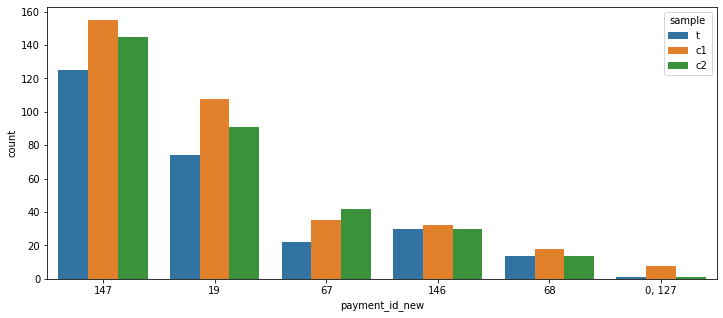

In [ ]:
# отсртируем датафрейм users по частоте значений из колонки payment_id
payment_counts = transactions['payment_id_new'].value_counts()
payment_frequency_map = payment_counts.to_dict()
transactions['payment_frequency'] = transactions['payment_id_new'].map(payment_frequency_map)
transactions.sort_values('payment_frequency', ascending=False, inplace = True)

# посмотрим на графике распределение payment_id
plt.figure(figsize = (12, 5))
sns.countplot(data=transactions, x="payment_id_new", hue="sample");

 Распределения визуально не отличаются.

In [ ]:
 # сравним test и control_2
print('p-value =', st.chi2_contingency(payment_table[['t', 'c2']])[1])

p-value = 0.548787020524394


In [ ]:
# сравним test и control_1
print('p-value =', st.chi2_contingency(payment_table[['t', 'c1']])[1])

p-value = 0.3433396086375376


In [ ]:
# сравним control_2 и control_1
print('p-value =', st.chi2_contingency(payment_table[['c1', 'c2']])[1])

p-value = 0.23256117298919868


Отсутствие статистически значимых различий в распределениях пользователей по значению `payment_id_new` между группами.


In [ ]:
 # удалим временные столбцы
transactions.drop(['payment_frequency', 'payment_id_new'], axis=1, inplace=True)

###  Посмотрим колонку from_page

In [ ]:
page_table = transactions.pivot_table(index = 'from_page', columns = 'sample', values = 'uid', aggfunc = 'count')
page_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
from_page,,,
empty_likes,90.0,96.0,68.0
trial_vip_popup,56.0,45.0,48.0
none,34.0,32.0,34.0
autoreply_message,29.0,24.0,27.0
menu,28.0,14.0,24.0
promo_09,21.0,22.0,18.0
popular_users_chat,4.0,1.0,10.0
left_sidebar_menu,15.0,25.0,7.0
dating,9.0,10.0,5.0


In [ ]:
# создадим колонку from_page_temp
other_pages = ['super_popup', 'likes', 'empty_mutual', 'delivery_vip', 'coins_popup', 'admins', 'empty_admins', 'no_sympathy',
              'refund_VP', 'refund_WP', 'refung_AP', 'user_profile', 'send_message', 'ad_to_photo', 'popular_users_block',
              'sympathy', 'popular_users_chat', 'gifts', 'fans', 'dating', 'autorefill', 'left_sidebar_menu']
to_other_page = {}
for o_p in other_pages:
    to_other_page[o_p] = 'other_pages'
transactions['from_page_temp'] = transactions['from_page'].map(to_other_page).fillna(transactions['from_page'])

page_table = transactions.pivot_table(index = 'from_page_temp', columns = 'sample', values = 'uid', aggfunc = 'count')
page_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
from_page_temp,,,
empty_likes,90,96,68
trial_vip_popup,56,45,48
other_pages,98,90,47
none,34,32,34
autoreply_message,29,24,27
menu,28,14,24
promo_09,21,22,18


In [ ]:
product_counts = transactions['product_type'].value_counts()
product_frequency_map = product_counts.to_dict()
transactions['product_frequency'] = transactions['product_type'].map(product_frequency_map)
transactions.sort_values('product_frequency', ascending=False, inplace = True)

 C помощью теста хи-квадрат попарно проверим выборки на наличие статистически значимых различий

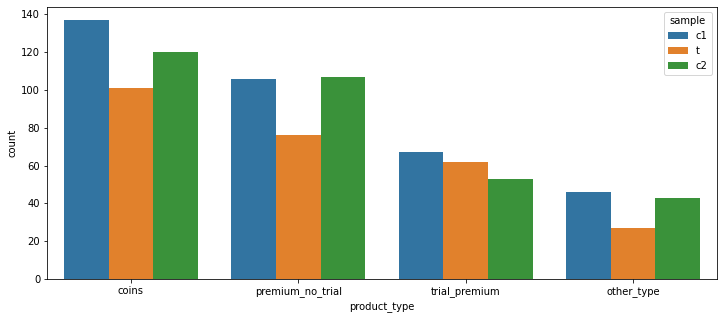

In [ ]:
 plt.figure(figsize = (12, 5))
sns.countplot(data=transactions, x="product_type", hue="sample");

In [ ]:
 # сравним test и control_1
print('p-value =', st.chi2_contingency(page_table[['c1', 't']])[1])

p-value = 0.1522597861202392


In [ ]:
# сравним test и control_2
print('p-value =', st.chi2_contingency(page_table[['c2', 't']])[1])

p-value = 0.012334250193158536


In [ ]:
 # сравним control_2 и control_1
print('p-value =', st.chi2_contingency(page_table[['c2', 'c1']])[1])

p-value = 0.4981598792007532


Между выборками **test** и **control_2** выявлены **статистически значимые различия** при уровне значимости 0,05.  

Возможная причина — наличие зависимости между параметром `from_page` и платёжеспособностью пользователя или его склонностью к приобретению премиум-подписки. Этот вопрос требует **дополнительного изучения**.

Для остальных пар выборок статистически значимых различий не обнаружено.


In [ ]:
 # удалим временные столбцы
transactions.drop(['from_page_temp', 'from_page_frequency'], axis=1, inplace=True, errors='ignore')

###  Колонка product_type

In [ ]:
 transactions.product_type.value_counts()


coins               358
premium_no_trial    289
trial_premium       182
other_type          116
Name: product_type, dtype: int64

In [ ]:
product_table = transactions.pivot_table(index = 'product_type', columns = 'sample', values = 'uid', aggfunc = 'count')
product_table.sort_values(by = 't', ascending = False)

sample,c1,c2,t
product_type,,,
coins,137,120,101
premium_no_trial,106,107,76
trial_premium,67,53,62
other_type,46,43,27


Распределения визуально не отличаются.


In [ ]:
# сравним test и control_1
print('p-value =', st.chi2_contingency(product_table[['t', 'c1']])[1])

p-value = 0.4644498338547721


In [ ]:
# сравним test и control_2
print('p-value =', st.chi2_contingency(product_table[['t', 'c2']])[1])

p-value = 0.12258482989892143


In [ ]:
# сравним control_2 и control_1
print('p-value =', st.chi2_contingency(product_table[['c2', 'c1']])[1])

p-value = 0.7379804129542318


Статистически значимых различий в распределении транзакций по product_type в разных выборках нет.

###  Посмотрим колонку revenue

In [ ]:
# считаем сумму выручки для каждого клиента из transactions
revenue_sum = transactions.groupby(['uid', 'sample']).agg(revenue_sum = ('revenue', 'sum')).sort_values(by = 'revenue_sum').reset_index()
revenue_sum

,uid,sample,revenue_sum
0,891317289,c2,481
1,891777708,t,624
2,891789270,c2,728
3,891653790,c1,728
4,891914322,t,741
...,...,...,...
521,891778551,c2,81796
522,892236423,t,86996
523,892038759,t,123565
524,891178380,t,129870


In [ ]:
# берём столбцы 'uid' и 'revenue' из таблицы users
revenue_from_users = users[['uid', 'total_revenue', 'sample']].sort_values(by = 'total_revenue')
revenue_from_users

,uid,total_revenue,sample
0,892309896,0.0,t
8508,891442878,0.0,t
8509,892264314,0.0,t
8510,891254049,0.0,c1
8511,891328464,0.0,c2
...,...,...,...
9608,891778551,81796.0,c2
4168,892236423,86996.0,t
9556,892038759,123565.0,t
8397,891178380,129870.0,t


In [ ]:
# сводим таблицы revenue_sum и total_revenue
revenue = revenue_sum.merge(revenue_from_users).sort_values(by = 'total_revenue', ignore_index=True)
revenue

,uid,sample,revenue_sum,total_revenue
0,892355163,c1,30264,0
1,960936960,c1,806,26
2,891317289,c2,481,481
3,891777708,t,624,624
4,891653790,c1,728,728
...,...,...,...,...
521,891778551,c2,81796,81796
522,892236423,t,86996,95823
523,892038759,t,123565,123565
524,891178380,t,129870,129870


 Уже видно, что есть строки, где revenue_sum и total_revenue не совпадают

In [ ]:
 # найдём на эти строки
revenue.query("(total_revenue - revenue_sum) != 0")

,uid,sample,revenue_sum,total_revenue
0,892355163,c1,30264,0
1,960936960,c1,806,26
37,892062660,c2,1261,2522
39,892202526,t,1794,2691
189,892009254,c2,4719,7072
215,891252072,c1,7553,8814
277,892045743,c2,8814,10075
278,891862596,c2,8814,10075
279,891365490,c1,8814,10075
280,891508155,t,9165,10101


In [ ]:
 # посчитаем сумму выручки для каждого клиента
orig_revenue_sum = orig_transactions.groupby(['uid', 'sample']).agg(revenue_sum = ('revenue', 'sum')).sort_values(by = 'revenue_sum').reset_index()
orig_revenue_sum

,uid,sample,revenue_sum
0,891317289.0,c2,481.0
1,891777708.0,t,624.0
2,891653790.0,c1,728.0
3,891789270.0,c2,728.0
4,891914322.0,t,741.0
...,...,...,...
521,891778551.0,c2,81796.0
522,892236423.0,t,95823.0
523,892038759.0,t,123565.0
524,891178380.0,t,129870.0


In [ ]:
 orig_revenue = orig_revenue_sum.merge(revenue_from_users).sort_values(by = 'total_revenue', ignore_index=True)
orig_revenue

,uid,sample,revenue_sum,total_revenue
0,892355163.0,c1,30264.0,0
1,960936960.0,c1,806.0,26
2,891317289.0,c2,481.0,481
3,891777708.0,t,624.0,624
4,891789270.0,c2,728.0,728
...,...,...,...,...
521,891778551.0,c2,81796.0,81796
522,892236423.0,t,95823.0,95823
523,892038759.0,t,123565.0,123565
524,891178380.0,t,129870.0,129870


In [ ]:
 orig_revenue.query("(total_revenue - revenue_sum) != 0")

,uid,sample,revenue_sum,total_revenue
0,892355163.0,c1,30264.0,0
1,960936960.0,c1,806.0,26
423,892275462.0,t,58968.0,14885


Из 23 пользователей у 20 несовпадения по суммарнму revenue связаны с удалением дубликатов из таблицы transactions. Поэтому заменим значения total_revenue из таблицы users суммами revenue из transactions.

In [ ]:
# посмотрим на транзакции
orig_revenue.query("(total_revenue - revenue_sum) != 0").merge(transactions)

,uid,sample,revenue_sum,total_revenue,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,product_frequency
0,892355163.0,c1,30264.0,0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264,68,super_popup,other_type,116
1,960936960.0,c1,806.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type,116
2,960936960.0,c1,806.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type,116
3,960936960.0,c1,806.0,26,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type,116
4,892275462.0,t,58968.0,14885,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885,68,super_popup,other_type,116
5,892275462.0,t,58968.0,14885,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type,116


 Не все транзакции учтены в total_revenue. Поэтому оставшиеся 3 значения total_revenue также заменим суммами revenue из transactions, которые уже посчитаны в таблице revenue_sum.

In [ ]:
users = users.merge(revenue_sum, how = 'left')
users.total_revenue = users.revenue_sum.fillna(users.total_revenue)
revenue_from_users = users[['uid', 'total_revenue', 'sample']].sort_values(by = 'total_revenue')
revenue = revenue_sum.merge(revenue_from_users).sort_values(by = 'total_revenue', ignore_index=True)
revenue.query("(total_revenue - revenue_sum) != 0")

,uid,sample,revenue_sum,total_revenue


In [ ]:
# удалим временный столбец из users
users.drop(['revenue_sum'], axis=1, inplace=True)

###  Посмотрим на распределение total_revenue

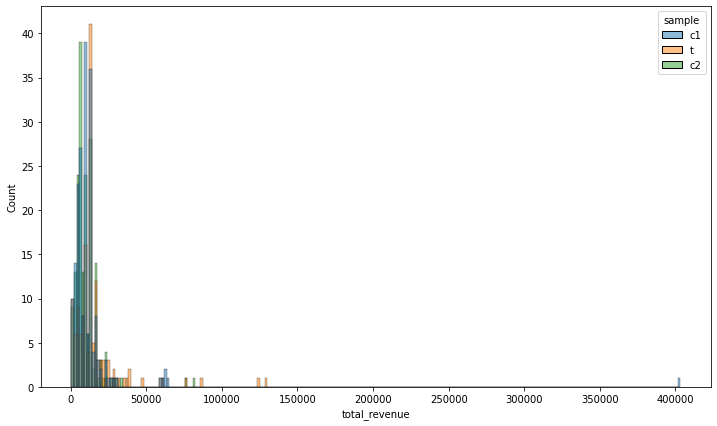

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(data=users[users.total_revenue > 0], x="total_revenue", hue="sample");

 Большинство значений total_revenue находятся ниже границы 50000.

In [ ]:
users[users.total_revenue > 50000][['uid', 'country', 'total_revenue', 'sample', 'age', 'was_premium', 'is_premium']] \
    .sort_values(by = 'total_revenue', ascending = False)

,uid,country,total_revenue,sample,age,was_premium,is_premium
7581,892333905,Italy,403104.0,c1,22,1,1
8397,891178380,Spain,129870.0,t,42,1,1
9556,892038759,United Arab Emirates,123565.0,t,26,1,1
4168,892236423,United States of America,86996.0,t,23,1,1
9608,891778551,United Arab Emirates,81796.0,c2,30,1,1
5125,891346269,Argentina,75647.0,t,34,1,1
8088,892307238,Spain,75647.0,c2,29,1,1
25,892216461,United States of America,64298.0,c1,19,1,1
12819,891383310,Turkey,63037.0,c1,22,1,1
10722,892366260,United Kingdom (Great Britain),63024.0,c1,26,1,1


В выборке **control_1** зафиксировано аномально высокое значение `total_revenue` — **403104**, что существенно превышает типичные значения для контрольных групп.

Кроме того, именно в этой выборке присутствуют пользователи, зарегистрированные в **2015 году**, что противоречит условию эксперимента о новых пользователях.

В связи с этим, чтобы избежать потенциального искажения результатов при сравнении с тестовой группой, более целесообразно использовать **группу `control_2`**, в которой подобных аномалий не обнаружено.


###  Посмотрим, как ошибки в данных влияют на метрику ARPU

In [ ]:
# создаём пандасовские серии uid c ошибками в joined_at и paid_at
err_uid_1 = transactions.groupby(['uid', 'paid_at']) \
    .agg(count = ('from_page', 'count'), page_nunique = ('from_page', 'nunique')) \
    .sort_values(by = 'page_nunique', ascending = False) \
    .query("count > 1") \
    .reset_index()['uid']
err_uid_2 = transactions.query("paid_at - joined_at < '0 days 00:00:00'").reset_index(drop=True)['uid']
 # создаём общий список удаляемых uid
err_uid_list = pd.concat([err_uid_1, err_uid_2]).unique()
 # создаём датафрейм crop_users, в котором удалены uid с ошибками
crop_users = users[~users['uid'].isin(err_uid_list)]
 # ARPU в кропнутом датафрейме
crop_users.groupby(['sample'])['total_revenue'].mean()[1:]

sample
c2    313.440332
t     336.404310
Name: total_revenue, dtype: float64

In [ ]:
 # ARPU в исходном датафрейме
orig_users.groupby(['sample'])['total_revenue'].mean()[1:]

sample
c2    450.384146
t     534.080316
Name: total_revenue, dtype: float64

## Влияние ошибок в данных на ARPU

Анализ показал, что ошибки в данных могут привести к искажению показателя ARPU на **31%** в контрольной группе и на **37%** в тестовой.  

Проверим, являются ли эти различия **статистически значимыми**.

Для сравнения средних значений ARPU между датафреймами `crop_users` и `orig_users` (с разбивкой по выборкам) был использован **t-тест**, так как он позволяет оценить различия между средними значениями.

Дополнительно был проведён **тест Левена** для проверки гипотезы о равенстве дисперсий. Результат теста Левена использовался для установки параметра `equal_var` в функции `ttest_ind`.

### Гипотезы:

- **Нулевая гипотеза (H₀):** различий между выборками нет.
- **Альтернативная гипотеза (H₁):** различия есть.
- **Уровень значимости:** 0,05


In [ ]:
# сравним данные по тестовым выборкам
crop_test = crop_users.query("sample == 't'")['total_revenue']
orig_test = orig_users.query("sample == 't'")['total_revenue']
equal_var = st.levene(crop_test, orig_test)[1] > 0.05
print('p-value =', st.ttest_ind(crop_test, orig_test, equal_var = equal_var)[1], '\nequal_var =', equal_var)



p-value = 0.01635949010815069 
equal_var = False


In [ ]:
 # сравним данные по выборкам control_2
crop_control_2 = crop_users.query("sample == 'c2'")['total_revenue']
orig_control_2 = orig_users.query("sample == 'c2'")['total_revenue']
equal_var = st.levene(crop_control_2, orig_control_2)[1] > 0.05
print('p-value =', st.ttest_ind(crop_control_2, orig_control_2, equal_var = equal_var)[1], '\nequal_var =', equal_var)

p-value = 0.01764830786341694 
equal_var = False


## Оценка влияния ошибок на ARPU

Параметр `equal_var = False` как для контрольной, так и для тестовой выборки указывает на наличие **статистически значимых различий в дисперсиях** `total_revenue` между `crop_users` и `orig_users` по результатам теста Левена.

Поскольку **p-value < 0.05** в обеих группах, нулевая гипотеза отклоняется. Это означает, что **ошибки в данных могут приводить к статистически значимому искажению метрики ARPU**, которая является основной метрикой эксперимента.



## 2. Выводы по результатам EDA

Целью этапа EDA являлась **предобработка данных и оценка их пригодности** для анализа результатов эксперимента.

### Обработка пропусков и дубликатов:
- В таблице `users` в колонках `coins`, `visit_days`, `was_premium` и `is_premium` обнаружены пропущенные значения — заменены на **нули**.
- В таблице `transactions` выявлено **630 строк без информации** — удалены.
- Обнаружено и удалено **33 дубликата** в `transactions`.

### Аномалии в датах:
- В `transactions` выявлены **противоречия между `joined_at` и `paid_at`**:
  - 80 строк с **одновременными транзакциями** у одного пользователя.
  - 163 строки, где **дата оплаты раньше даты регистрации**.
  - 3 строки с **датой регистрации в 2015 году**.
- Решено **не удалять** эти записи, поскольку причина неизвестна, а удаление может повлиять на метрики.

### Проблемы с выручкой:
- Обнаружены **23 случая расхождения** между суммой `revenue` в `transactions` и `total_revenue` в `users`. Значения `total_revenue` были пересчитаны.

### Другие проблемы:
- Поле `payment_id` **не является уникальным**, как заявлено. Из-за невозможности однозначной интерпретации **исключено из дальнейшего анализа**.
- Проверена **однородность распределения пользователей** по полу, возрасту, региону и другим признакам между группами.
- В `control_1` обнаружено **аномально высокое значение** `total_revenue = 403104`.
- Выявлена **неоднородность по `from_page`** между `test` и `control_2`.
- Возможное **ошибочное удаление 33 дубликатов**: из-за отсутствия уникального `payment_id` и наличия одновременных транзакций.

### Влияние на метрики:
- Выявленные ошибки могут искажать ARPU на **31% в контрольной** и **37% в тестовой** выборках.

**Вывод:** данные условно пригодны для анализа. Для продолжения требуется допущение, что **низкое качество данных не приводит к искажению результатов**.



## 3. Выбор метрик

Поскольку цель бизнеса — **увеличение выручки**, ключевые метрики связаны с монетизацией премиум-подписки.

### 3.1 Основная метрика:
- **ARPU** (Average Revenue Per User) — средняя выручка на пользователя.  
  Показывает, увеличился ли доход в тестовой группе по сравнению с контрольной.  
  Используется для оценки **успешности эксперимента**.

### 3.2 Дополнительные метрики:
- **ARPPU** (Average Revenue Per Paying User) — средняя выручка на платящего пользователя.
- **Конверсия в `premium_no_trial`** — доля пользователей, оформивших премиум без пробного периода.
- **Общая конверсия в премиум** — с учётом как пробного, так и платного периода.

---

## 4. Проверка корректности сплитования

Во время EDA была проведена **оценка однородности распределения** пользователей по различным признакам: регион, возраст, пол, коэффициент привлекательности и др.

- Использовались статистические тесты:
  - **Хи-квадрат** — для категориальных признаков.
  - **Критерий Манна–Уитни** — для числовых признаков.

**Ни один из тестов не выявил статистически значимых различий (p > 0.05)** — это свидетельствует о корректной работе механизма сплитования.



## 5. Анализ результатов A/B-теста

Для анализа результатов эксперимента сравниваются выборки:

- **Test**
- **Control_2** (вместо `control_1`, чтобы избежать влияния аномалий)


###  ARPU и ARPPU

In [ ]:
# расчитаем ARPU для выборок, то есть найдём среднее значение total_revenue
users.groupby(['sample'])['total_revenue'].mean()[1:]

sample
c2    447.466463
t     541.370938
Name: total_revenue, dtype: float64

## Сравнение ARPU между тестовой и контрольной группами

Значение **ARPU в тестовой выборке оказалось выше на 21%** по сравнению с контрольной группой.

Для проверки статистической значимости этого различия был применён **t-тест**, поскольку он позволяет сравнивать средние значения между двумя независимыми выборками.

Несмотря на то, что распределения могут отклоняться от нормального, **достаточный размер выборок** позволяет опираться на **центральную предельную теорему**, согласно которой распределение средних значений приближается к нормальному.

Для оценки равенства дисперсий между тестовой и контрольной группами использовался **тест Левена** (уровень значимости 0,05). Его результат был передан в параметр `equal_var` функции `ttest_ind`.

### Гипотезы:

- **Нулевая гипотеза (H₀):** различий в ARPU между группами нет.
- **Альтернативная гипотеза (H₁):** различия в ARPU присутствуют.
- **Уровень значимости:** 0,05


In [ ]:
equal_var = st.levene(users.query("(sample == 't')")['total_revenue'], users.query("(sample == 'c2')")['total_revenue'])[1] > 0.05
c = users.query("sample == 'c2'")['total_revenue']
t = users.query("sample == 't'")['total_revenue']
print('p-value =', st.ttest_ind(c, t, equal_var = equal_var)[1], '\nequal_var =', equal_var)

p-value = 0.24226293606710184 
equal_var = True


## Результаты сравнения ARPU

Результаты t-теста показали **p-value = 0.2423**.  
Параметр `equal_var = True` указывает на **отсутствие статистически значимых различий в дисперсиях** между тестовой и контрольной группами по результатам теста Левена.

Так как p-value превышает установленный уровень значимости 0.05, мы **не можем отклонить нулевую гипотезу**.  
Это означает, что несмотря на то, что **ARPU в тестовой группе выше на 21%**, это отличие **не является статистически значимым** и может быть связано со случайными колебаниями в данных.


In [ ]:
# расчитаем ARPPU для выборок, то есть найдём среднее значение для всех total_revenue > 0
users.query("total_revenue > 0").groupby(['sample'])['total_revenue'].mean()[1:]

sample
c2    10203.192513
t     15974.150685
Name: total_revenue, dtype: float64

## Сравнение ARPPU между тестовой и контрольной группами

Значение **ARPPU в тестовой выборке на 57% выше**, чем в контрольной.

Для оценки статистической значимости различий был применён **t-тест**, поскольку он предназначен для сравнения средних значений между двумя независимыми выборками.

Хотя распределения ARPPU в выборках **не являются нормальными**, их объёмы достаточно велики, чтобы предполагать приближение распределения выборочных средних к нормальному согласно **центральной предельной теореме**.

Для проверки гипотезы о равенстве дисперсий использовался **тест Левена** с уровнем значимости 0.05. Результат теста передавался в параметр `equal_var` функции `ttest_ind`.

### Гипотезы:

- **Нулевая гипотеза (H₀):** средние значения ARPPU в группах не различаются.
- **Альтернативная гипотеза (H₁):** средние значения ARPPU различаются.
- **Уровень значимости:** 0.05


In [ ]:
c = users.query("(sample == 'c2') and (total_revenue > 0)")['total_revenue']
t = users.query("(sample == 't') and (total_revenue > 0)")['total_revenue']
equal_var = st.levene(c, t)[1] > 0.05
print('p-value =', st.ttest_ind(c, t, equal_var = equal_var)[1], '\nequal_var =', equal_var)

p-value = 0.0005720246264184832 
equal_var = False


## Результаты сравнения ARPPU

Результаты t-теста показали **p-value = 0.0006**.  
Параметр `equal_var = False` указывает на наличие **статистически значимых различий в дисперсиях** между тестовой и контрольной группами (по результатам теста Левена).

Поскольку p-value меньше уровня значимости 0.05, **нулевая гипотеза отклоняется**.  
Это свидетельствует о наличии **статистически значимых различий в ARPPU** между тестовой и контрольной выборками.

Таким образом, разница в ARPPU на 57% между группами **не случайна** и может быть интерпретирована как результат воздействия изменений в эксперименте.


 ###  Конверсия в premium_no_trial

In [ ]:
# по данным transactions создадим новую колонку признаков premium_no_trial и добавим её в таблицу users
premium_no_trial = \
transactions[transactions.product_type == 'premium_no_trial'].groupby('uid') \
    .agg(lambda x: 1) \
    .reset_index() \
    [['uid', 'country']] \
    .rename(columns = {'country': 'premium_no_trial'})
users = users.merge(premium_no_trial, how = 'left')
users['premium_no_trial'].fillna(0, inplace = True)
# число пользователей premium_no_trial и число всех пользователей в выборках
cr_premium_no_trial = users.groupby(['sample']).agg(premium_no_trial = ('premium_no_trial', 'sum'), all = ('premium_no_trial', 'count'))[1:]
cr_premium_no_trial

,premium_no_trial,all
sample,,
c2,102.0,4264
t,67.0,4308


In [ ]:
# конверсия в premium_no_trial
cr_premium_no_trial['premium_no_trial'] / cr_premium_no_trial['all'] * 100

sample
c2    2.392120
t     1.555246
dtype: float64

## Сравнение конверсии в `premium_no_trial`

Значение конверсии в `premium_no_trial` в **контрольной выборке на 54% выше**, чем в тестовой группе.

Для проверки статистической значимости различий между группами применён **Z-тест для пропорций**.  
Выбор Z-теста обоснован тем, что **размеры выборок и значения конверсий достаточно велики**, чтобы использовать **нормальную аппроксимацию**.

### Гипотезы:

- **Нулевая гипотеза (H₀):** различий в конверсии в `premium_no_trial` между группами нет.
- **Альтернативная гипотеза (H₁):** различия в конверсии присутствуют.
- **Уровень значимости:** 0.05


In [ ]:
premium_no_trial_count = users.groupby(['sample']).premium_no_trial.sum()[1:]
all_count = users.groupby(['sample']).premium_no_trial.count()[1:]
print('p-value =', smp.proportions_ztest(premium_no_trial_count, all_count)[1])

p-value = 0.005325105786331221


## Результаты сравнения конверсии в `premium_no_trial`

Результаты Z-теста для пропорций показали **p-value = 0.0053**.  
Так как p-value меньше уровня значимости 0.05, **нулевая гипотеза отклоняется**.

Это означает, что **конверсия в `premium_no_trial` в тестовой выборке статистически значимо ниже**, чем в контрольной — снижение составило **54%**.

➡️ Таким образом, эксперимент **оказал негативное влияние на конверсию платной подписки без пробного периода**, и это влияние статистически подтверждено.


In [ ]:
# удалим временные столбцы
users.drop(['premium_no_trial'], axis=1, inplace=True)

###  Премиум конверсия

In [ ]:
# по данным transactions создадим новую колонку признаков premium и добавим её в таблицу users
premium = \
transactions.query("product_type in ['trial_premium', 'premium_no_trial']").groupby('uid') \
    .agg(lambda x: 1) \
    .reset_index() \
    [['uid', 'country']] \
    .rename(columns = {'country': 'premium'})
users = users.merge(premium, how = 'left')
users['premium'].fillna(0, inplace = True)
# число пользователей premium и число всех пользователей в выборках
cr_premium = users.groupby(['sample']).agg(premium = ('premium', 'sum'), all = ('premium', 'count'))[1:]
cr_premium

,premium,all
sample,,
c2,155.0,4264
t,127.0,4308


In [ ]:
# конверсия в premium
cr_premium['premium'] / cr_premium['all'] * 100

sample
c2    3.635084
t     2.948004
dtype: float64

## Сравнение общей конверсии в `premium`

Конверсия в `premium` (включая и пробную, и платную подписки) в **контрольной выборке на 23% выше**, чем в тестовой.

Для оценки статистической значимости различий применён **Z-тест для пропорций**.  
Выбор этого теста обоснован тем, что **размеры выборок и значения конверсий** позволяют использовать **нормальную аппроксимацию**.

### Гипотезы:

- **Нулевая гипотеза (H₀):** различий в общей конверсии в `premium` между группами нет.
- **Альтернативная гипотеза (H₁):** различия в конверсии присутствуют.
- **Уровень значимости:** 0.05


In [ ]:
 premium_count = users.groupby(['sample']).premium.sum()[1:]
all_count = users.groupby(['sample']).premium.count()[1:]
print('p-value =', smp.proportions_ztest(premium_count, all_count)[1])

p-value = 0.07455815581024947


## Результаты Z-теста по конверсии в `premium`

Результаты Z-теста для пропорций показали **p-value = 0.0746**.  
Поскольку значение p-value превышает уровень значимости 0.05, **нулевая гипотеза не отклоняется**.

Это означает, что несмотря на то, что **конверсия в `premium` в контрольной группе была на 23% выше**, это различие **не является статистически значимым**.



## Финальные выводы

### Качество данных

Данные, собранные для эксперимента, имеют **серьёзные проблемы с качеством**, включая:
- ошибки и дубликаты,
- противоречивые даты регистрации и оплаты,
- неуникальные идентификаторы платежей,
- несоответствия между таблицами.

Наличие большого количества таких проблем **снижает доверие к данным в целом** и ставит под сомнение корректность результатов.  
**Тем не менее**, в рамках данного анализа принято допущение, что влияние этих проблем **не является критическим** для ключевых выводов по эксперименту.



### Результаты эксперимента

| Метрика                      | Результат                                       |
|-----------------------------|--------------------------------------------------|
| **ARPU**                    | Не изменился статистически значимо (p > 0.05)   |
| **ARPPU**                   | Увеличился на **57%**, статистически значимо (p < 0.05) |
| **Конверсия в `premium_no_trial`** | Снизилась на **54%**, статистически значимо (p < 0.05) |
| **Общая конверсия в `premium`**    | Не изменилась статистически значимо (p > 0.05)   |



## Заключение

Несмотря на положительную динамику ARPPU, **существенное снижение конверсии в `premium_no_trial`** и **отсутствие прироста ARPU** указывают на то, что **текущее изменение стоимости премиум-подписки нецелесообразно внедрять на всех пользователей**.

**Рекомендация:**  
Провести **повторный A/B-тест**, обеспечив надлежащее качество данных и контроль за потенциальными аномалиями на этапе сбора.
